In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = w.make_dataframe()

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Resample

### Downsampling

In [6]:
# Take out packets from router
df = df[df["DeviceType"]!="router"]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [7]:
df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

### Create downsampled trial dataframes

In [8]:
df_trials = []
num_trials = 10
for i in range(0,num_trials):
    # Down
    df_downsampled = w.downsample(X, y, df[df["Set"]=="test"])
    df_trials.append(df_downsampled)

In [9]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength", "Time",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

# Run trials

In [10]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = w.one_vs_all_classify(trial, features_list, y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports/Plots

### AUC

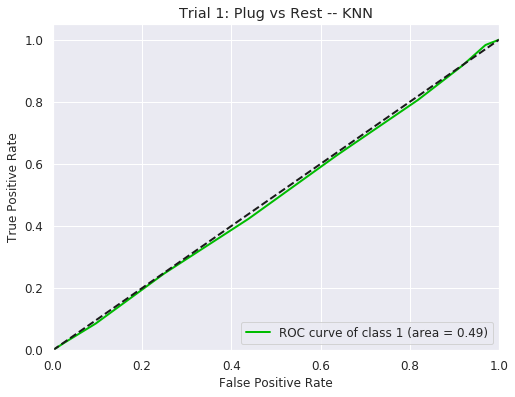

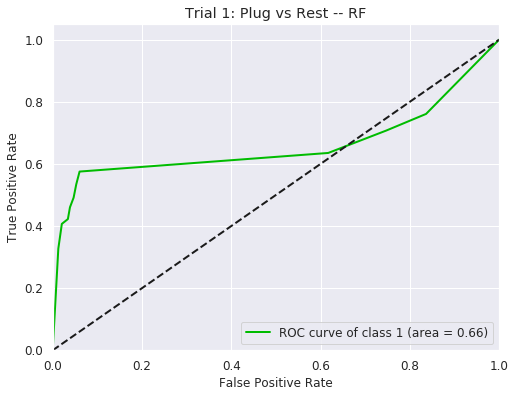

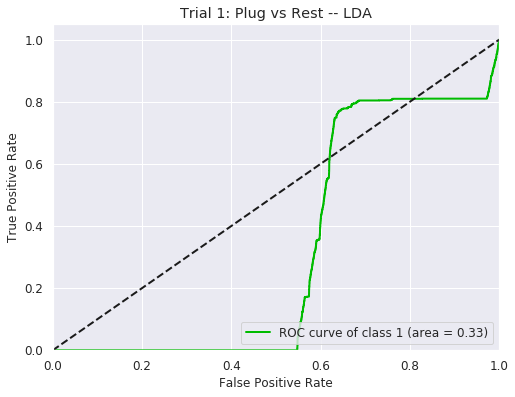

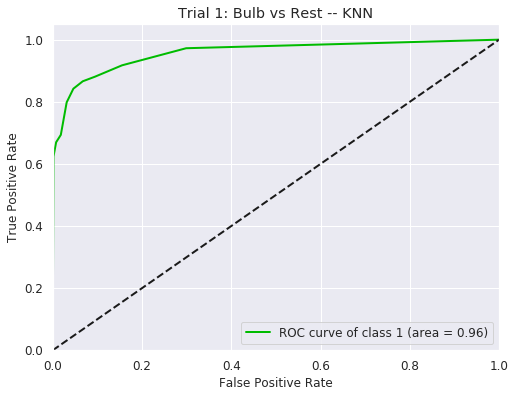

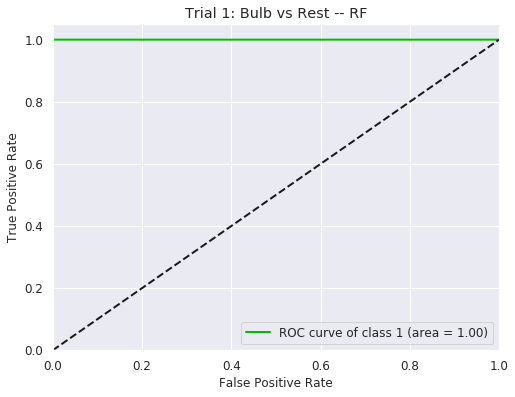

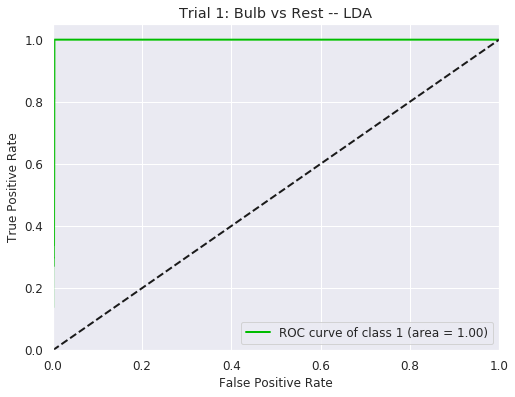

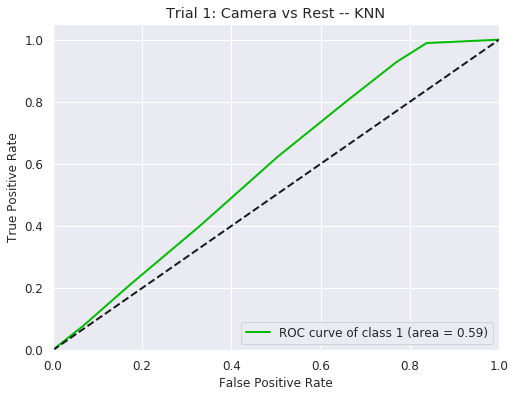

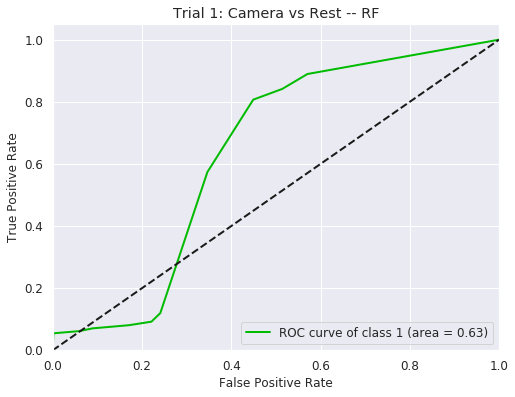

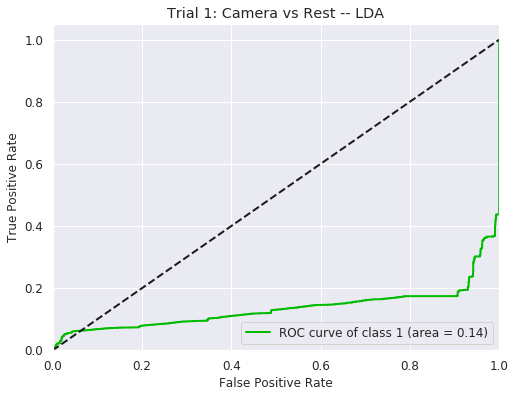

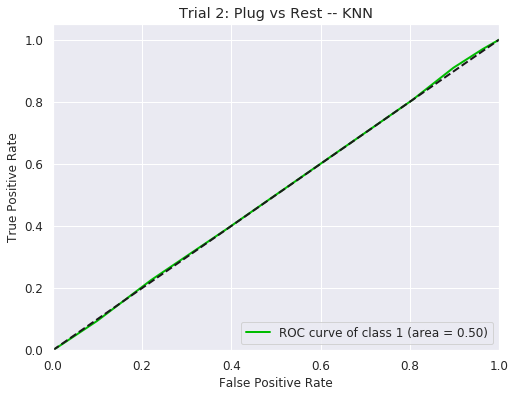

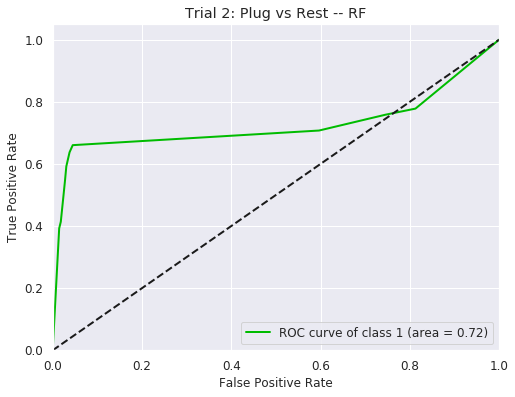

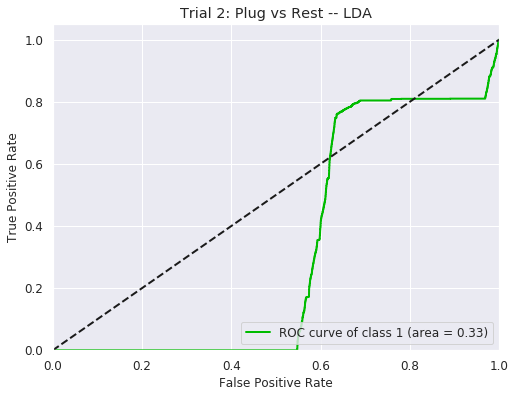

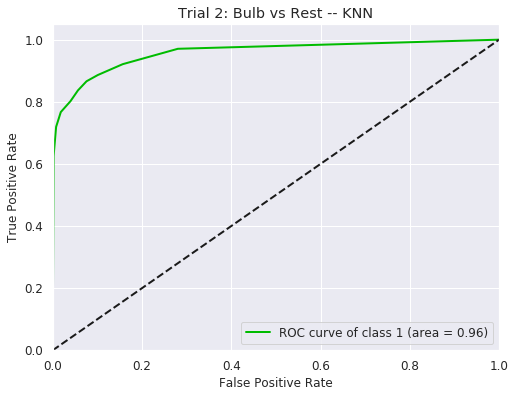

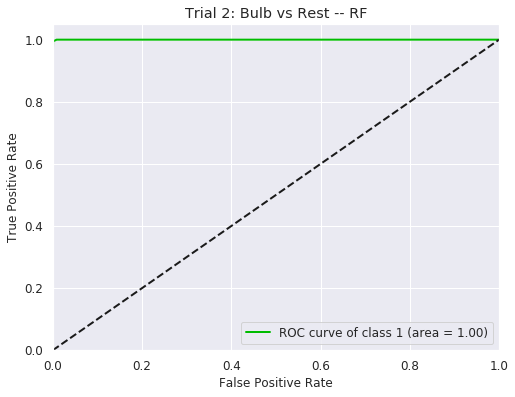

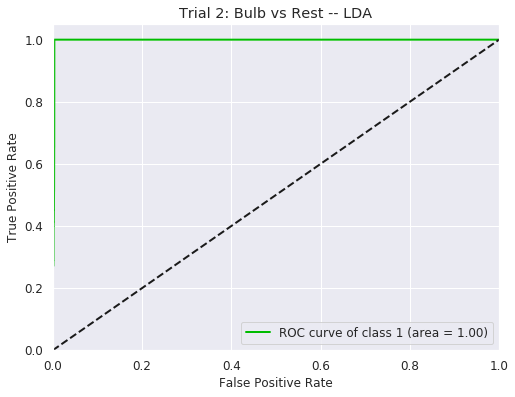

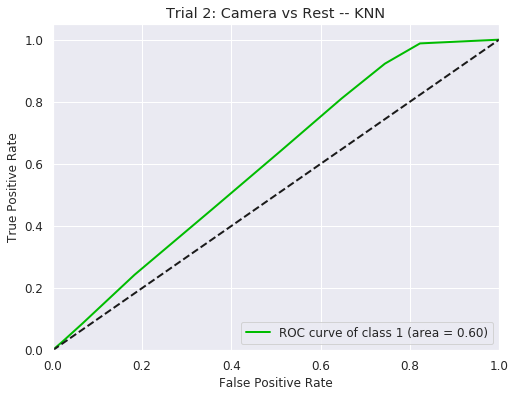

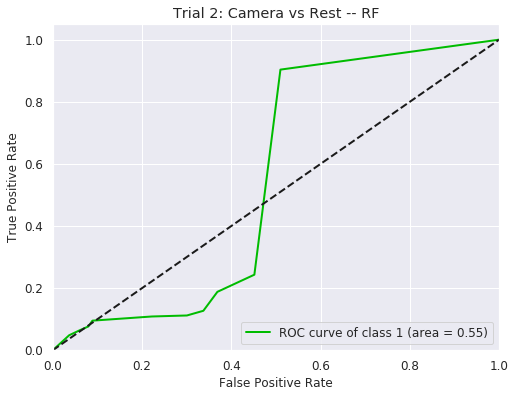

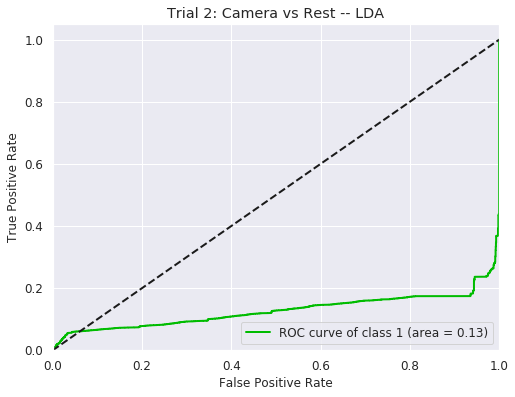

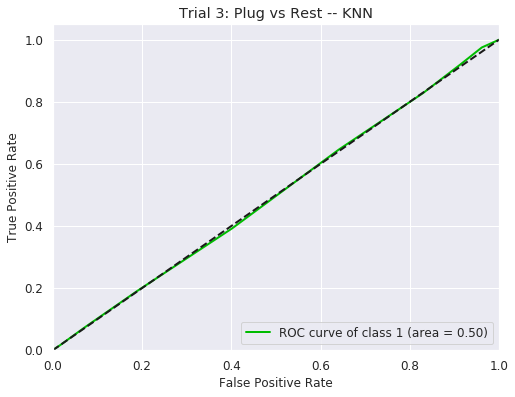

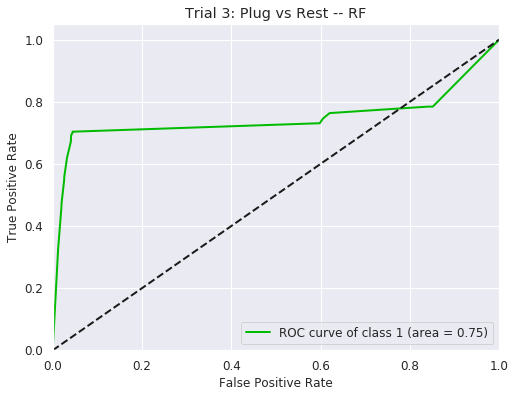

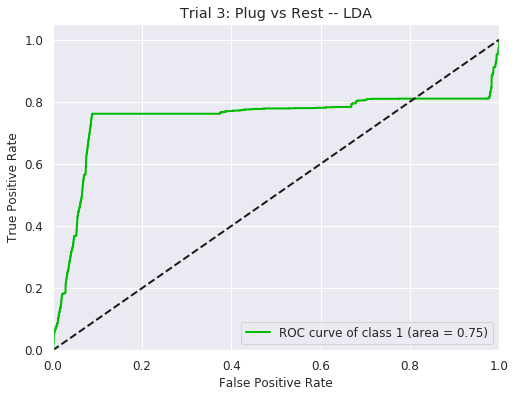

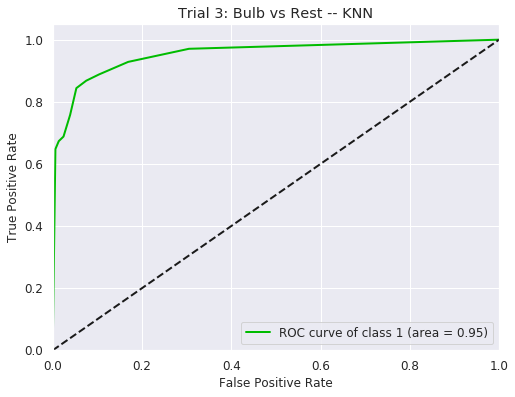

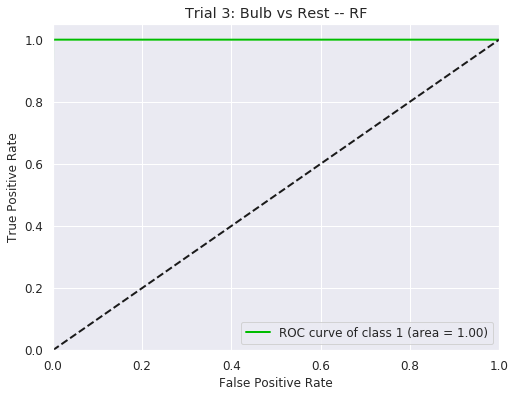

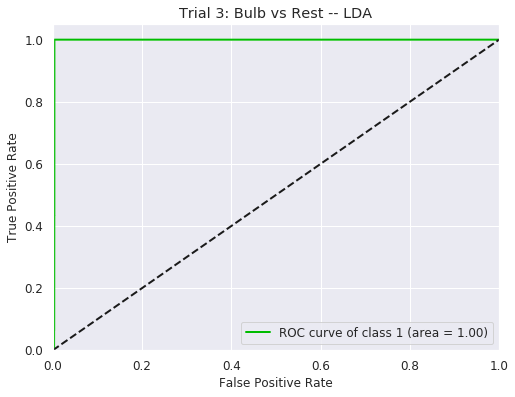

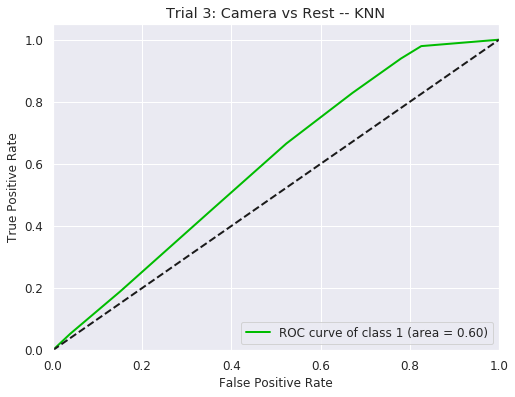

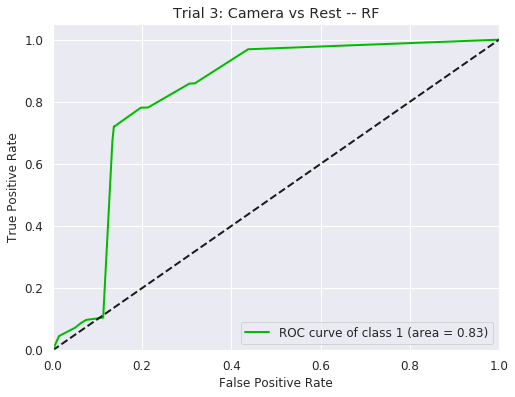

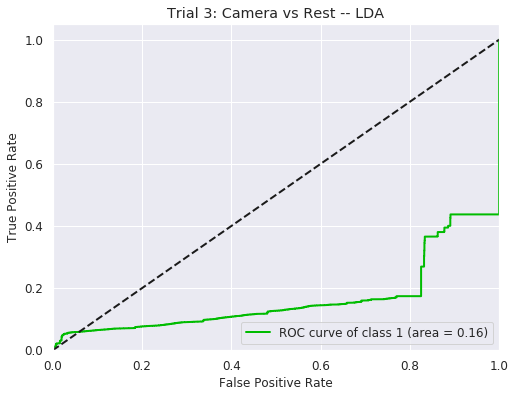

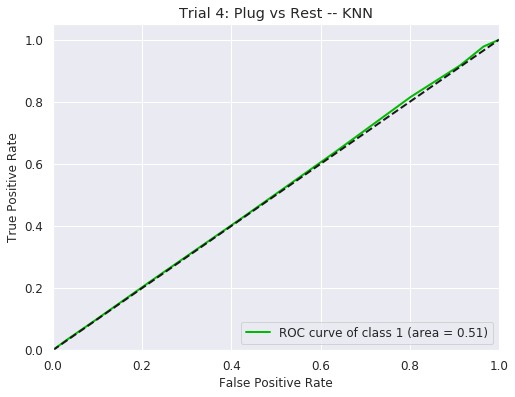

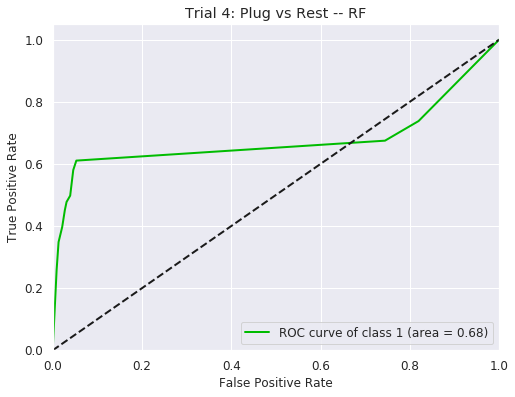

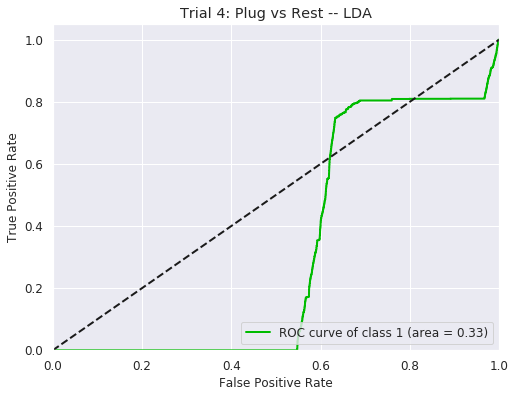

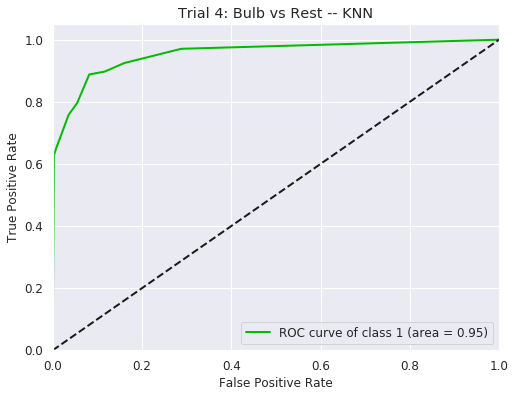

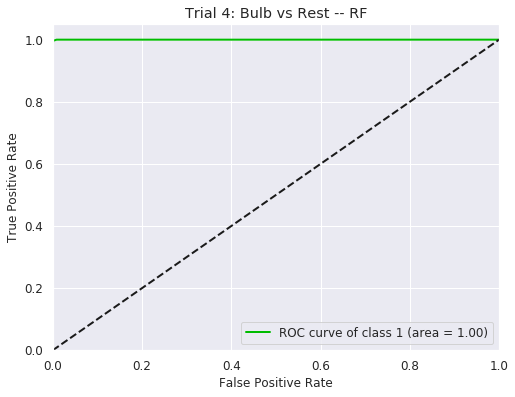

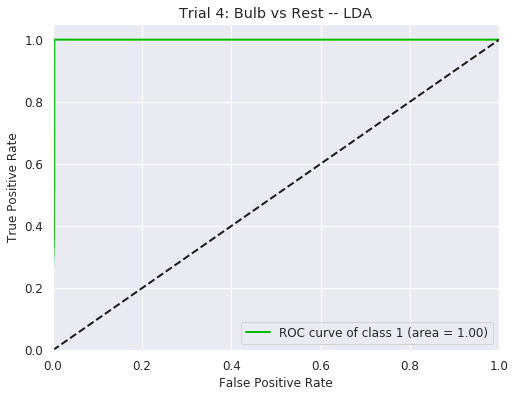

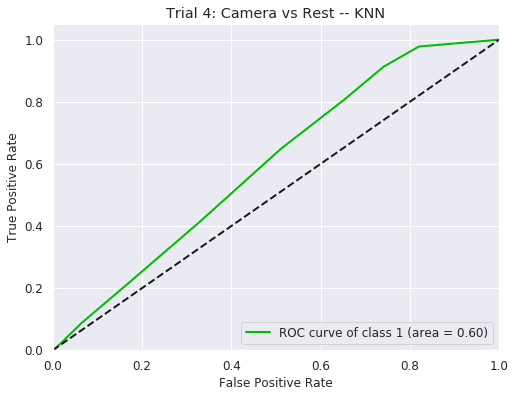

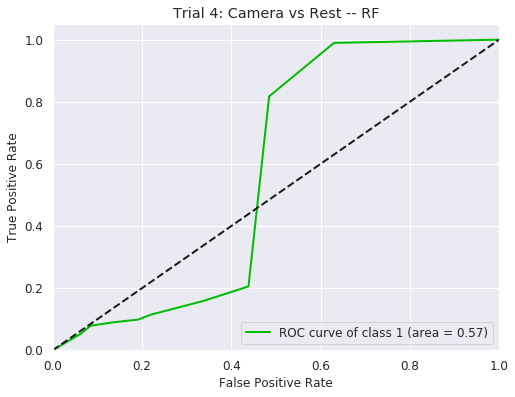

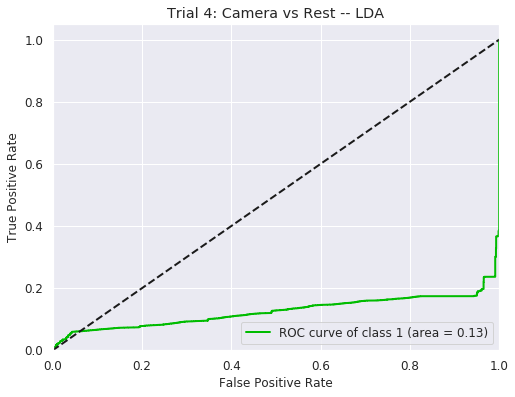

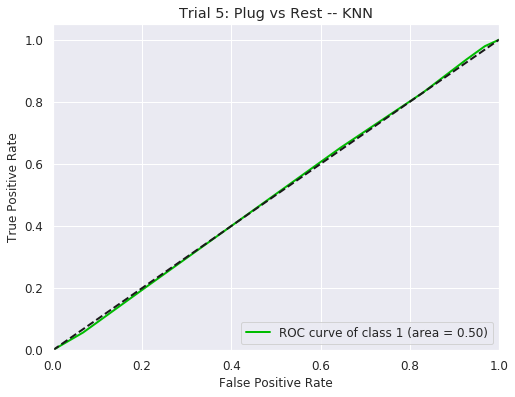

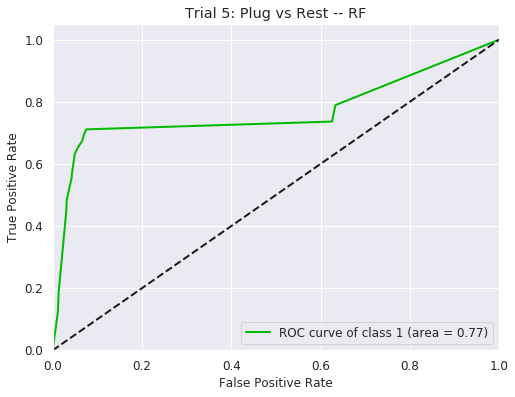

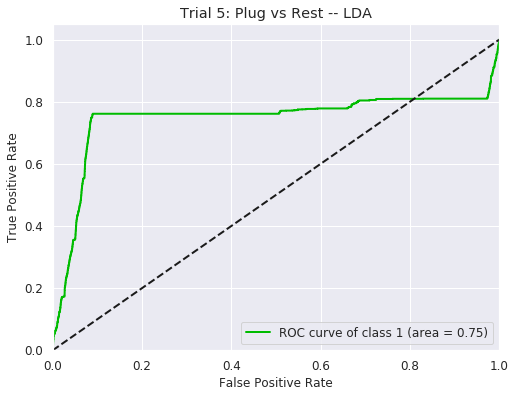

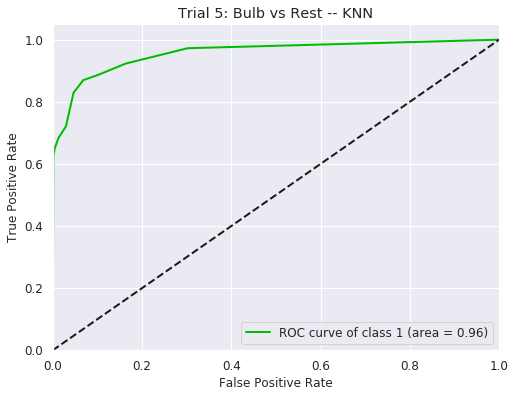

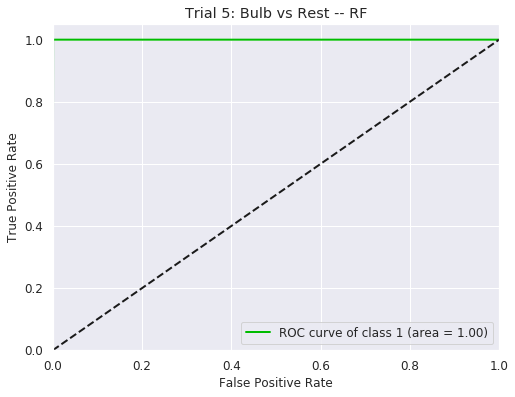

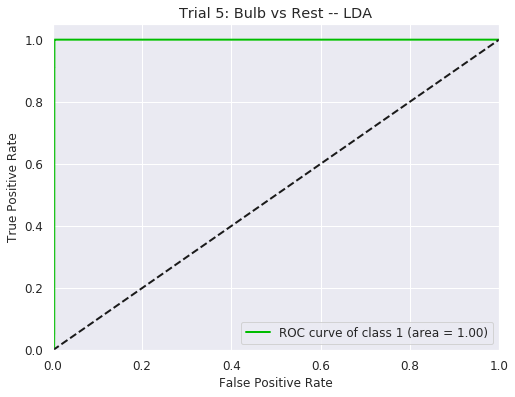

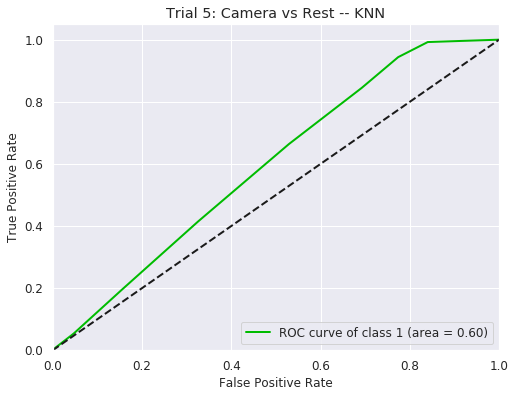

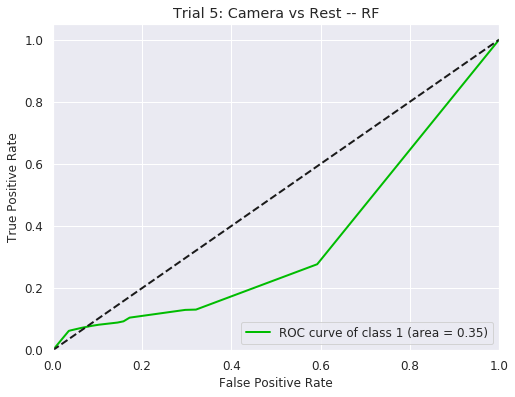

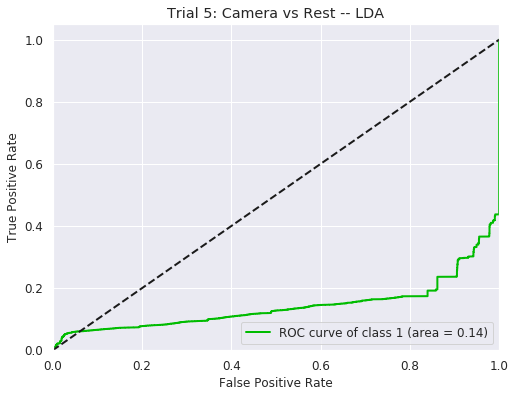

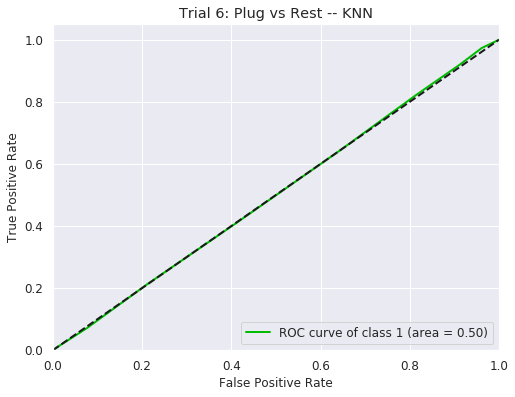

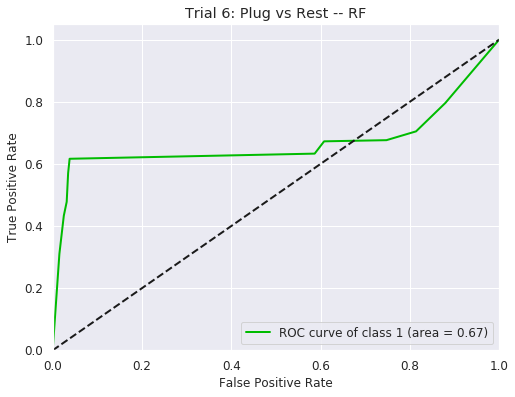

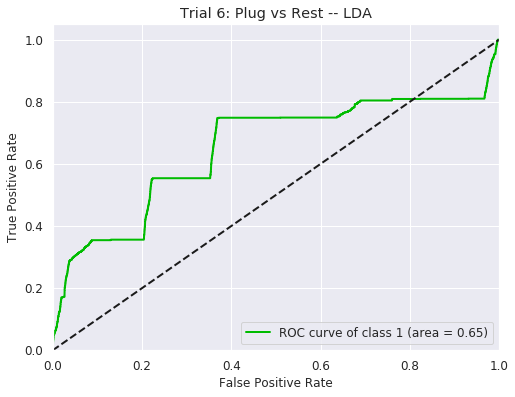

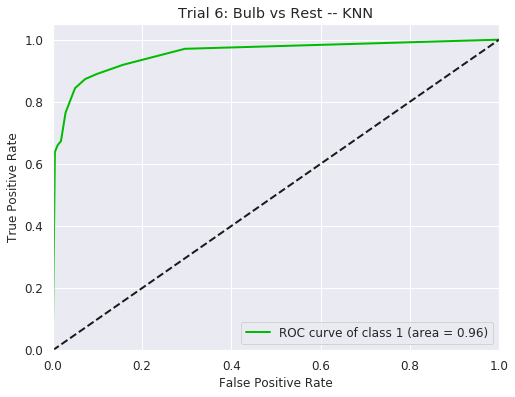

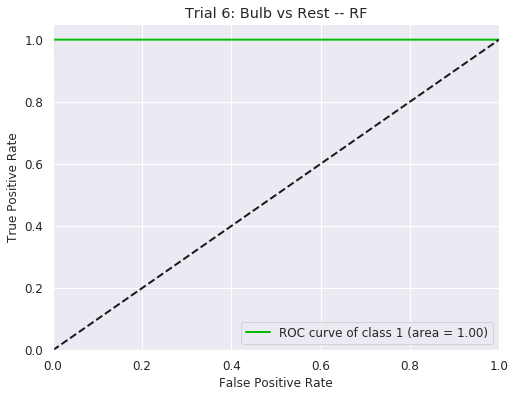

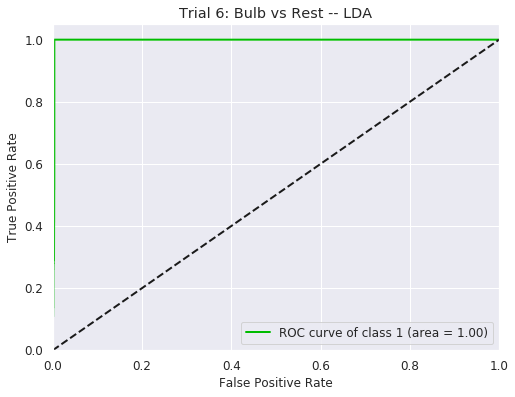

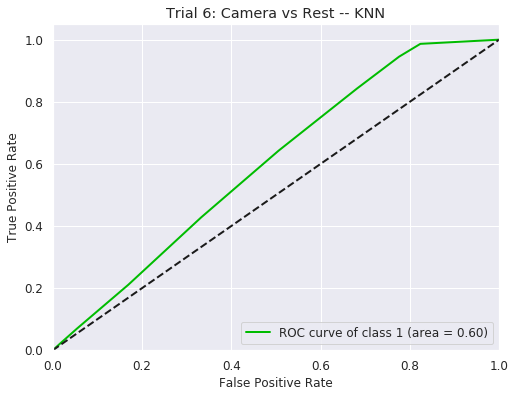

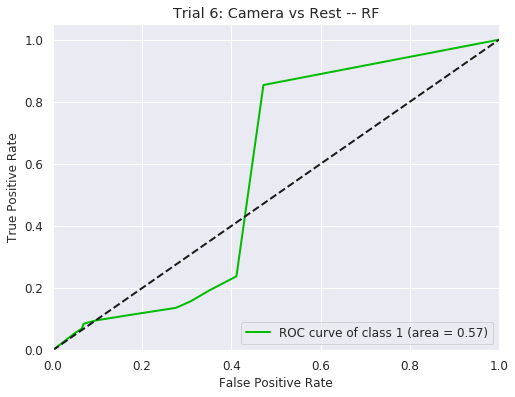

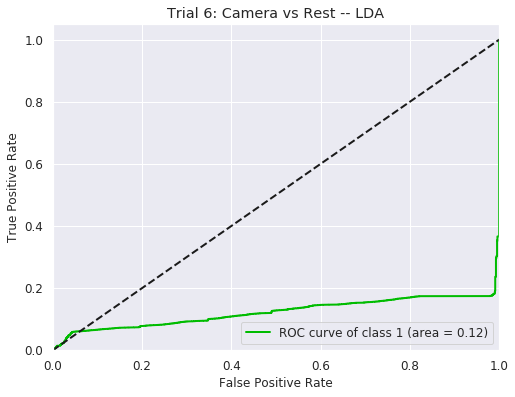

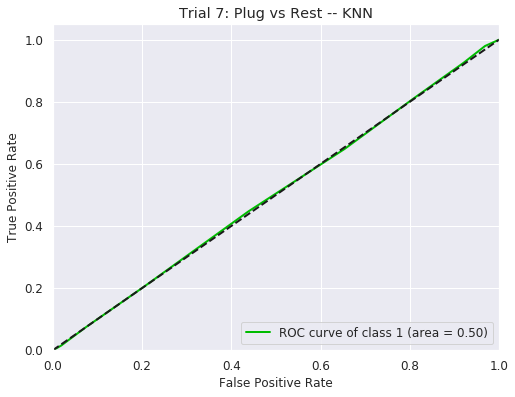

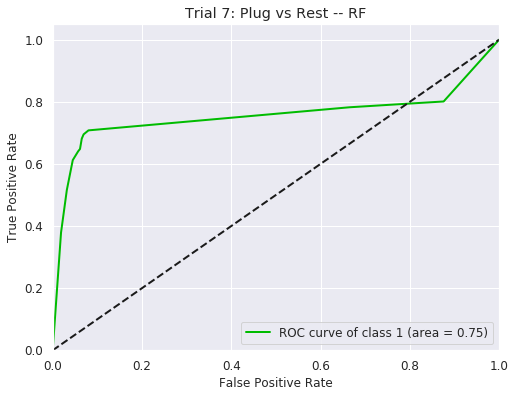

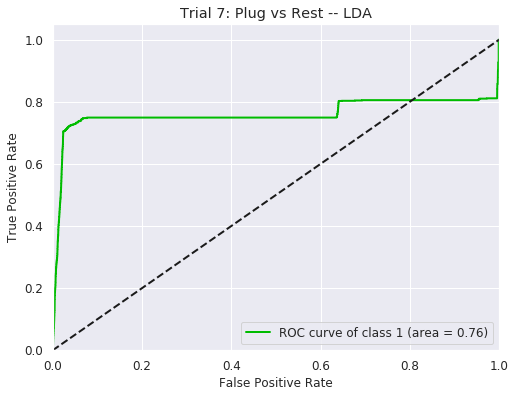

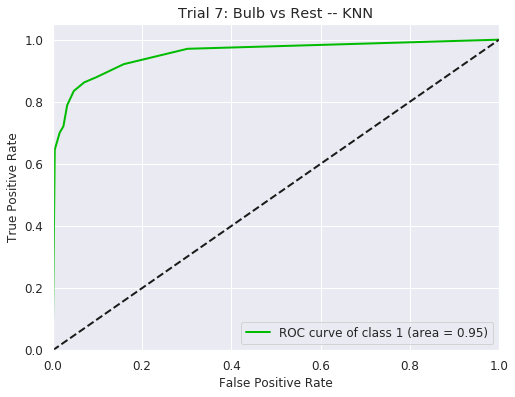

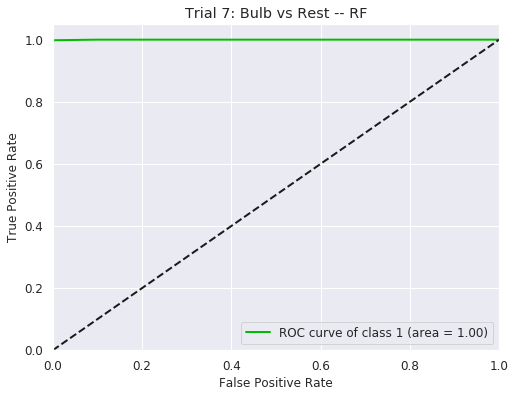

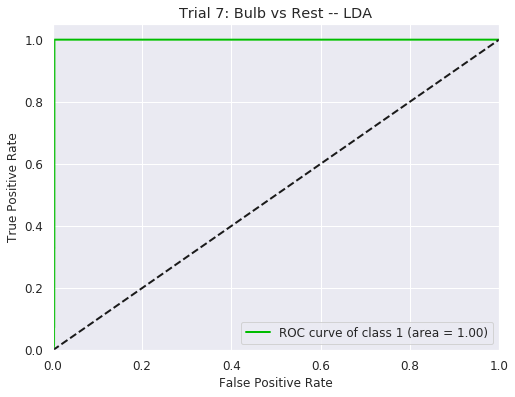

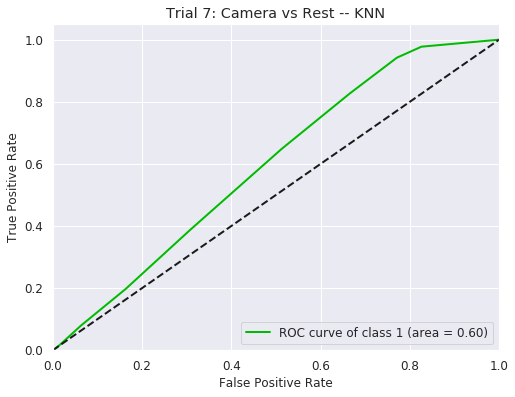

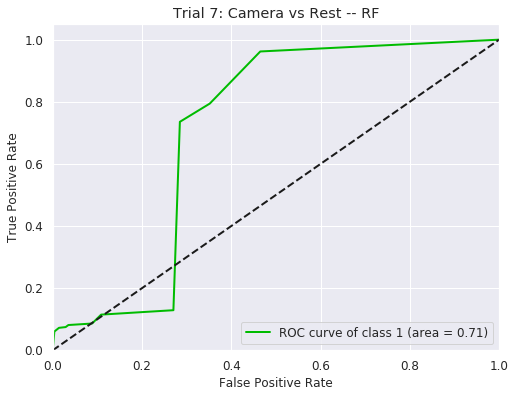

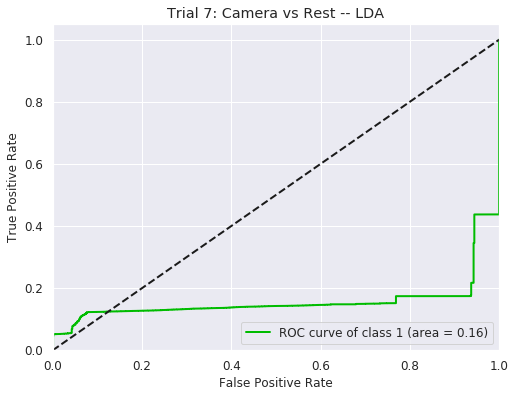

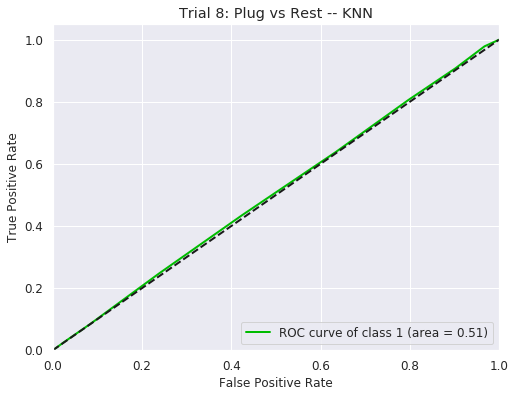

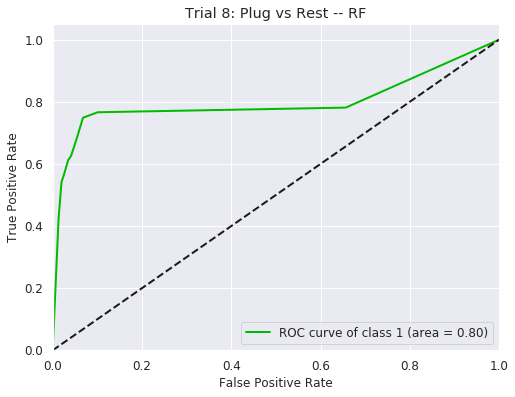

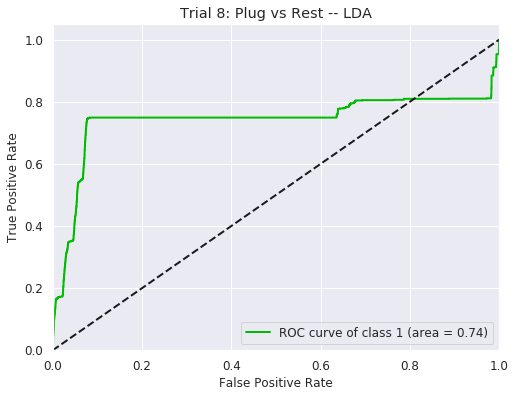

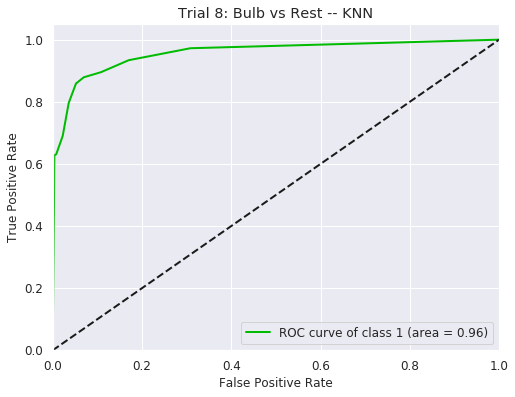

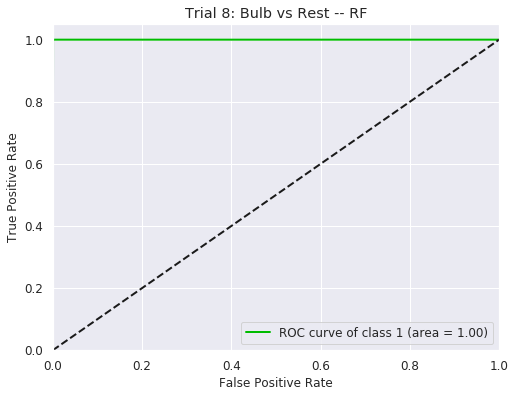

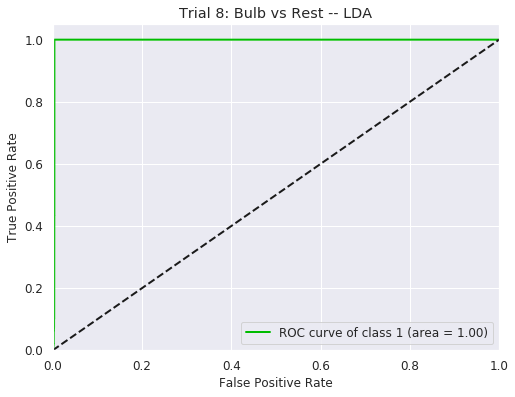

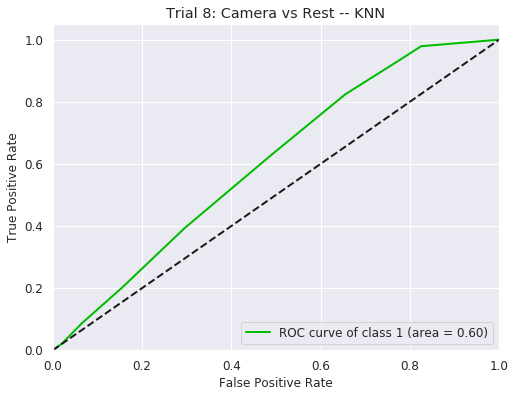

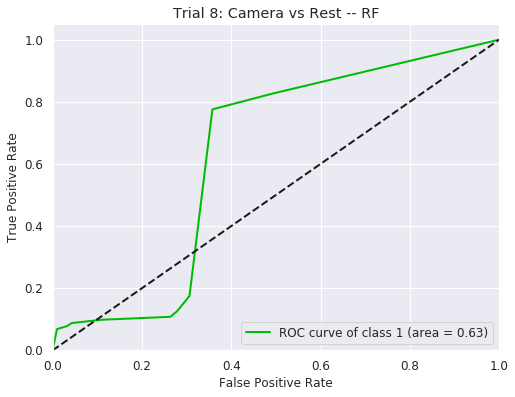

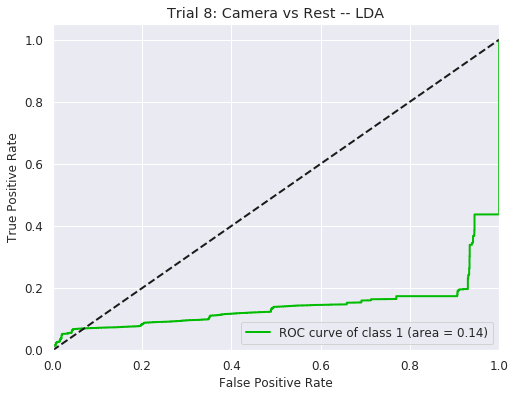

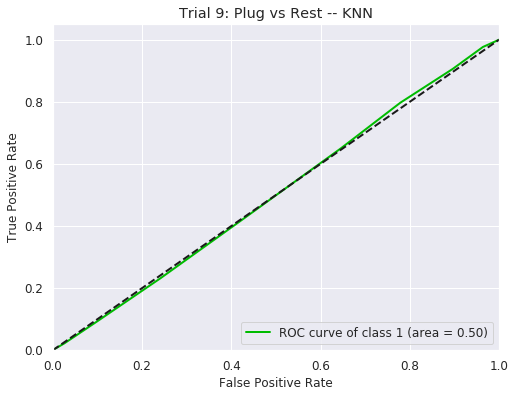

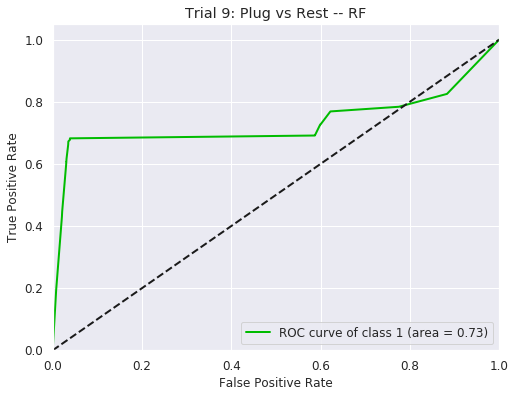

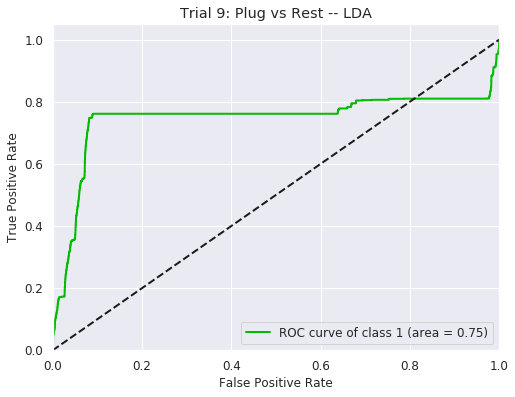

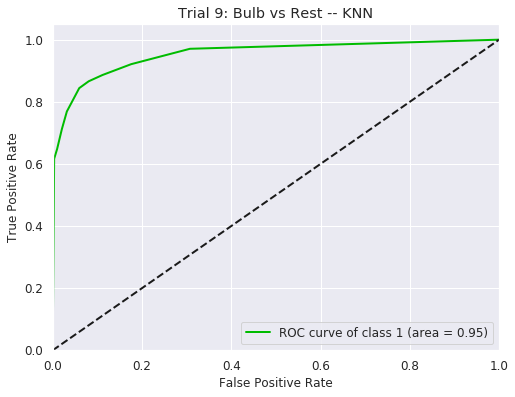

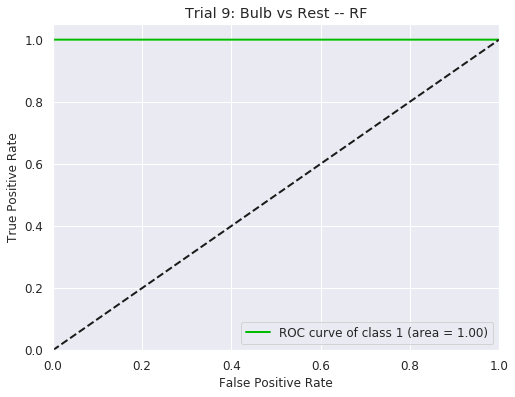

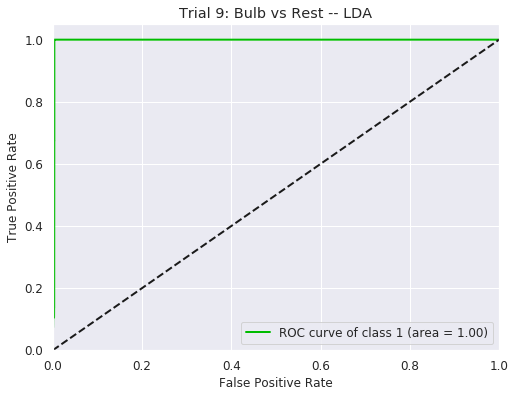

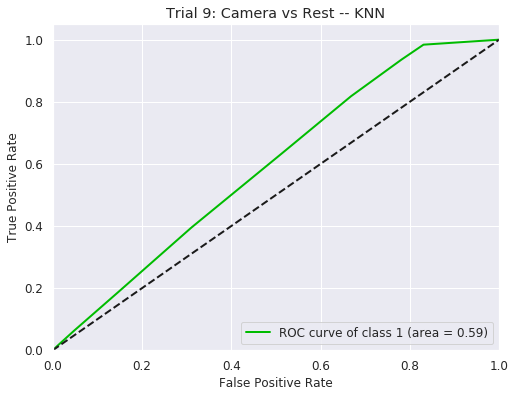

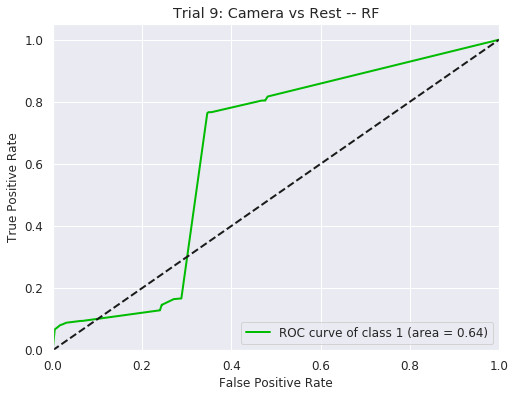

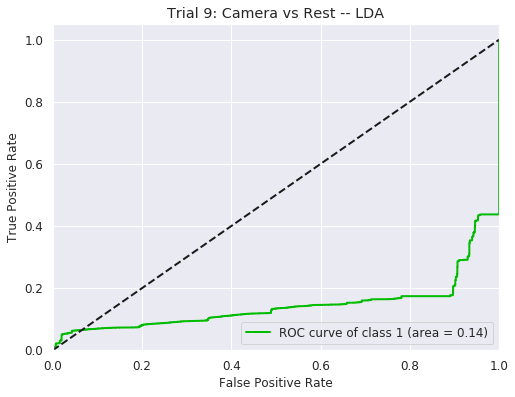

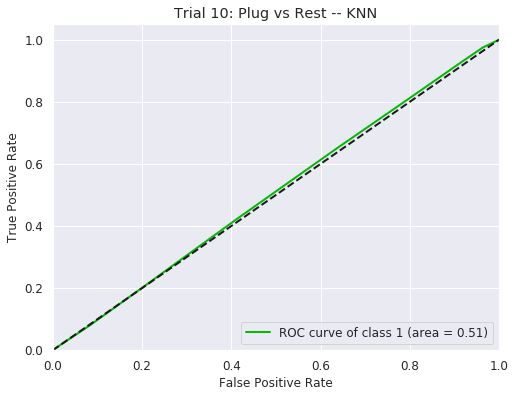

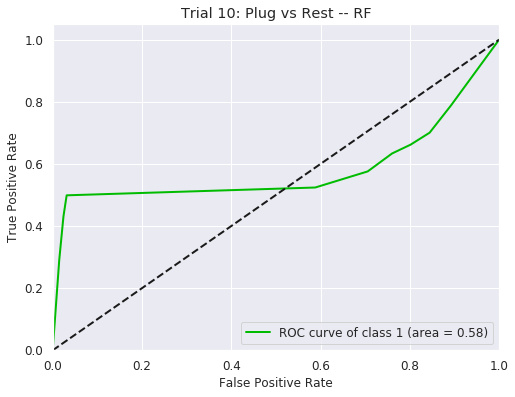

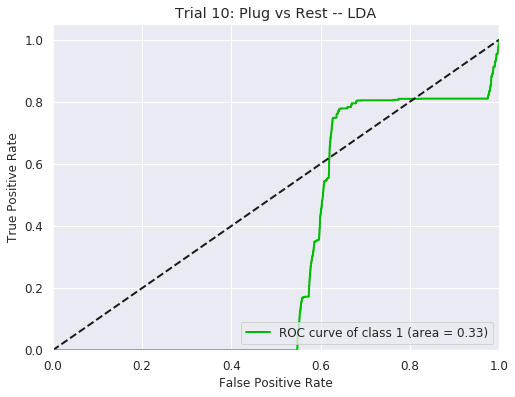

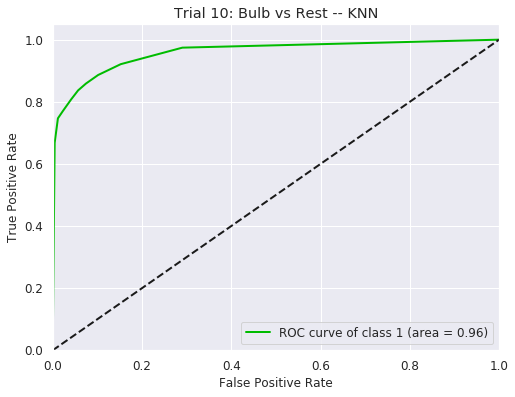

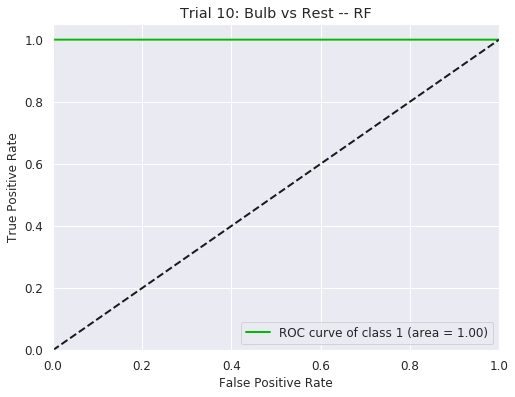

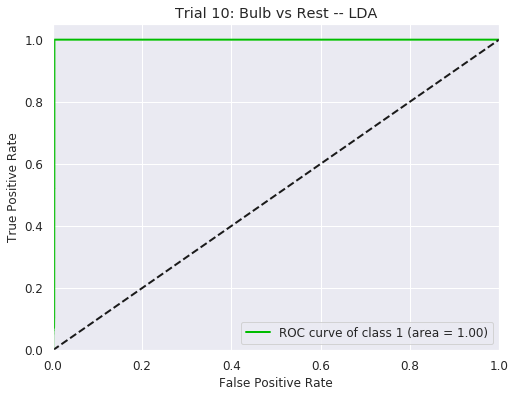

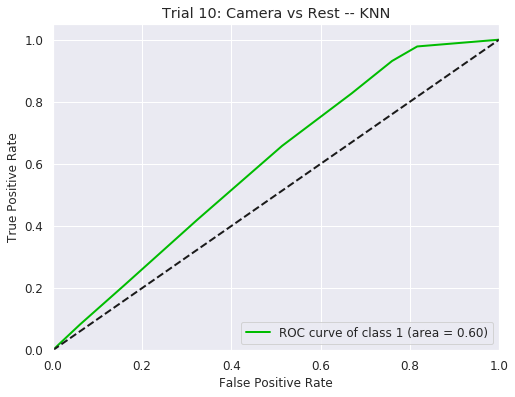

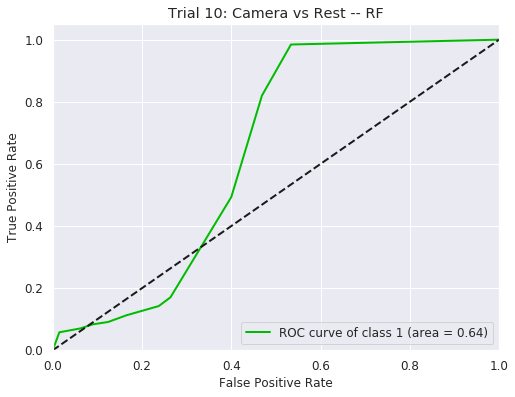

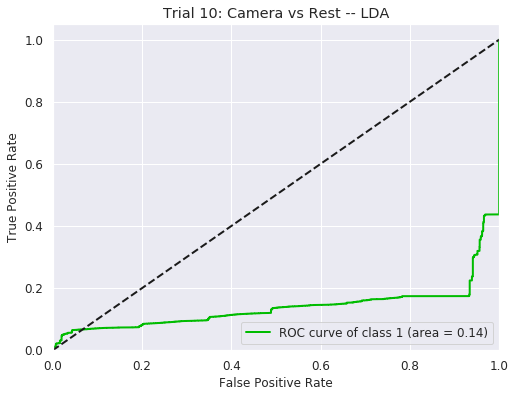

In [11]:
# Plotting ROC curves
sns.set(font_scale=1)
aucs = []

for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()

    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']
            
            # Calculate, store auc
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            aucs.append(auc)            
            
            # Plot ROC curve
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));

### Print csv results

In [12]:
df_alloutput = w.store_trial_results(trial_results)
df_alloutput['AUC'] = aucs
df_alloutput.to_csv('Results/wifi-alltrials.csv', mode='w')

In [13]:
df_performance_device = w.report_metrics_across('Device', df_alloutput)
display(df_performance_device)
df_performance_device.to_csv('Results/wifi-devtype-performance.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,TPR,SD_TPR,CI_TPR,FPR,SD_FPR,CI_FPR,FNR,SD_FNR,CI_FNR,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
plug,0.674605,0.214725,0.079747,0.500143,0.220835,0.082016,0.309605,0.223002,0.082821,0.499857,0.220835,0.082016,0.256372,0.236405,0.087799,0.594060,0.151002,0.056081
bulb,0.953576,0.061427,0.022813,0.945566,0.078816,0.029272,0.046226,0.062783,0.023317,0.054434,0.078816,0.029272,0.550484,0.320420,0.119001,0.984107,0.020460,0.007599
camera,0.261169,0.131470,0.048827,0.201737,0.156188,0.058007,0.243754,0.180163,0.066911,0.798263,0.156188,0.058007,0.863241,0.086275,0.032042,0.449566,0.233087,0.086566


In [14]:
df_performance_classifier = w.report_metrics_across('Classifier', df_alloutput)
display(df_performance_classifier)
df_performance_classifier.to_csv('Results/wifi-devtype-classifier.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,TPR,SD_TPR,CI_TPR,FPR,SD_FPR,CI_FPR,FNR,SD_FNR,CI_FNR,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
KNN,0.651735,0.217543,0.080793,0.557040,0.201971,0.075010,0.265877,0.158969,0.059040,0.442960,0.201971,0.075010,0.427228,0.359980,0.133693,0.684922,0.198762,0.073818
RF,0.671537,0.369067,0.137068,0.566622,0.377228,0.140099,0.096025,0.120228,0.044652,0.433378,0.377228,0.140099,0.703045,0.256998,0.095447,0.773730,0.184396,0.068483
LDA,0.566078,0.358087,0.132990,0.523782,0.430282,0.159803,0.237683,0.261021,0.096941,0.476218,0.430282,0.159803,0.539824,0.348038,0.129258,0.569081,0.374757,0.139181


In [15]:
device_types = ['bulb', 'camera', 'plug']
classifiers = ['KNN', 'LDA', 'RF']

### Time Performance

In [16]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in device_types:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 1.85829997063 seconds
(Bulb, KNN) : 0.242171049118 seconds
(Bulb, LDA) : 0.0104720592499 seconds
(Bulb, RF) : 0.0686061382294 seconds
(Camera, KNN) : 0.318109035492 seconds
(Camera, LDA) : 0.0206799507141 seconds
(Camera, RF) : 0.0972919464111 seconds
(Plug, KNN) : 0.242378950119 seconds
(Plug, LDA) : 0.0112750530243 seconds
(Plug, RF) : 0.0723130702972 seconds

Trial  1
Total time: 1.74531793594 seconds
(Bulb, KNN) : 0.241276025772 seconds
(Bulb, LDA) : 0.0103628635406 seconds
(Bulb, RF) : 0.069760799408 seconds
(Camera, KNN) : 0.262730121613 seconds
(Camera, LDA) : 0.0107748508453 seconds
(Camera, RF) : 0.077320098877 seconds
(Plug, KNN) : 0.243073940277 seconds
(Plug, LDA) : 0.0110120773315 seconds
(Plug, RF) : 0.0720338821411 seconds

Trial  2
Total time: 1.82100605965 seconds
(Bulb, KNN) : 0.283647060394 seconds
(Bulb, LDA) : 0.0105938911438 seconds
(Bulb, RF) : 0.076534986496 seconds
(Camera, KNN) : 0.27796292305 seconds
(Camera, LDA) : 0.0107531547546 second

### Feature Importance

In [17]:
# Extract feature importance values
df_featImp = pd.DataFrame()
for i,f in enumerate(w.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [18]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [19]:
feat_imp = df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False)
display(feat_imp)
feat_imp.to_csv('Results/wifi-feature_importance.csv', mode='w')

,Mean,StdDev,CI_MOE
Belkin,0.210041,0.203157,0.128488
PacketLength,0.193709,0.154277,0.097573
Dropcam,0.176698,0.212439,0.134358
QoS_Null,0.142207,0.131456,0.083140
Assoc_Packets,0.120056,0.080174,0.050707
Lifi,0.059466,0.067410,0.042634
QoS_Data,0.045842,0.050366,0.031854
Time,0.029401,0.019026,0.012033
Data,0.013176,0.011340,0.007172
Tp-link,0.009403,0.014567,0.009213


### Sampling Counts

In [20]:
print "Packet Counts Prior to Resampling"
print df["DeviceType"].value_counts()

Packet Counts Prior to Resampling
plug      85512
camera    71399
bulb       1231
Name: DeviceType, dtype: int64


Training Set plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

Test Set camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


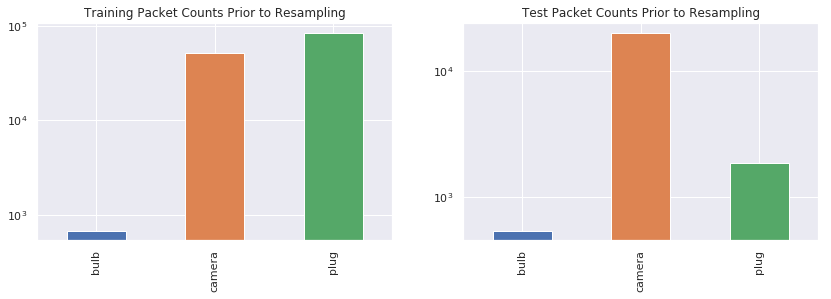

In [21]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling", logy=True);
print "Training Set", df_train["DeviceType"].value_counts()
print

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling", logy=True);
print "Test Set", df_test["DeviceType"].value_counts()

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


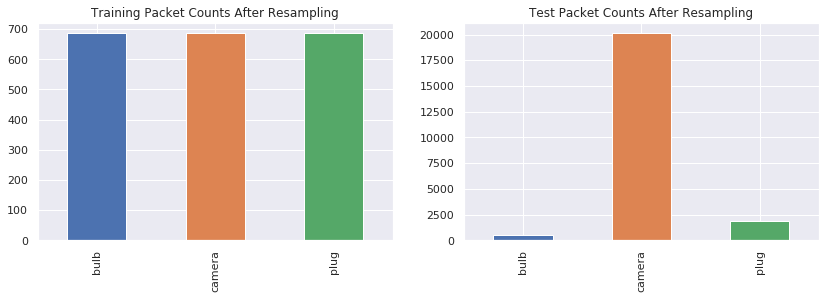

In [22]:
# Plot post-sampling
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
